## Basic working example of SSPC code 
 - Instructions & fixes on how to install SSPC see https://docs.google.com/document/d/1FVzLPGknWRjBspePV_aN__6bVgqxlth6Y7YP0vM6xdo/edit?usp=sharing  and ask in the channel (its a bit of a mess)  
 - download data_file from https://drive.google.com/file/d/1w-zSGV7LIKQeaT43oESPmEchRJU3syRk/view?usp=sharing -> this gives a file called `bps_output.h5' 
 - try code below

note: You might not need all the imports... (& feel free to change this code / update it) 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import astropy.constants as c
import astropy.units  as u

## you can undo the lines below (but it will be fun for making fancy plots!)
# to make the lines below work, you have to download the file 'PostProcessingScripts' from https://github.com/FloorBroekgaarden/common_code
# and put this in the same directory as this one, and then only use the bottom line from this code below 
import sys
# sys.path.append('../../common_code') 
# from PostProcessingScripts import * 

# to make the screen wider
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Example read in parameters from bps_data

the BBH parameters available are:  Index(['dco_mass_1', 'dco_mass_2', 'delay_time',
       'formation_efficiency_per_solar_mass', 'metallicity'],
      dtype='object')


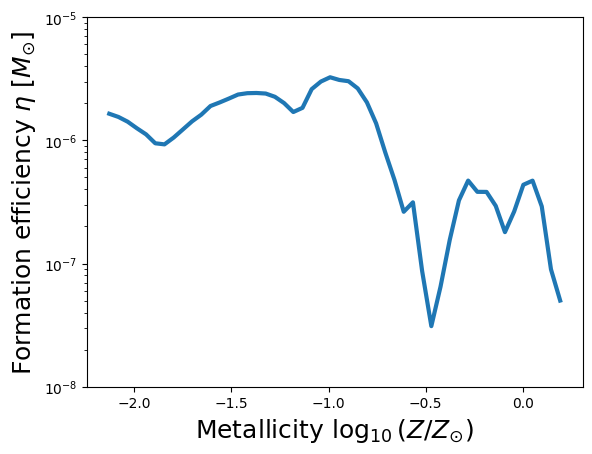

In [2]:

rel_path = '/Volumes/GROWL/GROWL_test_data/' # change this line 
bps_file_name = 'bps_output.h5'

full_path = rel_path + bps_file_name


df = pd.read_hdf(full_path, key="input_data")

# Inspect the available columns
print('the BBH parameters available are: ',  df.columns)

formation_efficiency_per_solar_mass = df['formation_efficiency_per_solar_mass'].values
metallicities = df["metallicity"].values



### make a plot 
fs=18
hist, bin_edges = np.histogram(np.log10(metallicities/0.0142), weights=formation_efficiency_per_solar_mass, bins=50, density=True)

bin_centers = (bin_edges[0:-1] + bin_edges[1:])/2
normalization = np.sum(formation_efficiency_per_solar_mass)

plt.plot(bin_centers, hist*normalization, lw=3)


plt.yscale('log')
plt.ylim(10**-8, 10**-5)

plt.ylabel(r'Formation efficiency $\eta \ [M_{\odot}]$', fontsize=fs)
plt.xlabel(r'Metallicity $\log_{10}(Z/Z_{\odot})$', fontsize=fs)
plt.show()



## Set up  S(Z,z)

In [3]:
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
import astropy.units as u
from typing import Union, Dict, List, Tuple, Optional
from dataclasses import dataclass
from pathlib import Path

import os
import json
import pkg_resources
import copy
import logging
import h5py

import copy
import logging
import pandas as pd
import sys

# sys.path.append('/Users/floorbroekgaarden/Projects/GitHub/syntheticstellarpopconvolve')
sys.path.insert(0, '/Users/floorbroekgaarden/Projects/GitHub/syntheticstellarpopconvolve') # fixed this to import sspc in jupyter notebook for me 
from syntheticstellarpopconvolve import convolve, default_convolution_config, default_convolution_instruction
from syntheticstellarpopconvolve.general_functions import generate_boilerplate_outputfile, extract_unit_dict, temp_dir

from syntheticstellarpopconvolve.starformation_rate_distributions import starformation_rate_distribution_vanSon2023
from syntheticstellarpopconvolve.metallicity_distributions import metallicity_distribution_vanSon2022
from syntheticstellarpopconvolve.general_functions import calculate_bincenters, calculate_bin_edges
from syntheticstellarpopconvolve.SFR_dict_plotting_routines import plot_sfr_dict

from syntheticstellarpopconvolve import convolve, default_convolution_config, default_convolution_instruction
from syntheticstellarpopconvolve.general_functions import temp_dir, generate_boilerplate_outputfile


#### step 1: set up S(Z,z) using metallicity range from simulation (given the simulation info)

##### note

Instead of using the SSPC example where we define the log metallicity bins based on sorting the unique metallicities, we isntead
read in the metallicities from the simulation, to understand what range of metallicity bins we want to use. 
This is helpful to do as some data (Adam's) has random Metallicities sampled, so the sorting would take forever. 

In the future we can probably do this direct though (calculate the S(Z,z) weights for each individual binary) . This is only an issue for Boesky data, so not important

In [4]:
nbins=200
metallicities = df["metallicity"].values
_, log_metallicity_bin_edges = np.histogram(np.log(metallicities), bins=nbins, density=True) # the weights dont matter - we just want to get bin_centers
log_metallicity_bin_centers = (log_metallicity_bin_edges[0:-1] + log_metallicity_bin_edges[1:])/2

print(min(metallicities), max(metallicities))

0.0001000001190803619 0.023315130630088447


#### Step 2  Set  up S(Z,z) for this simulation, and plot it:

(1e-05, 1)

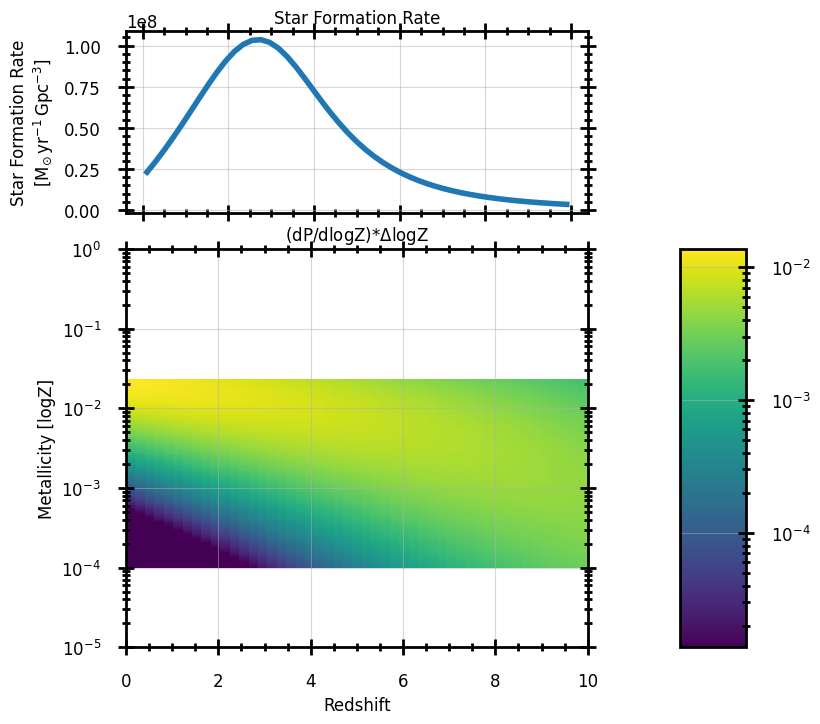

In [5]:



# convert
metallicity_bin_centers = np.exp(log_metallicity_bin_centers)
metallicity_bin_edges = np.exp(log_metallicity_bin_edges)

# Set up redshift bin info
num_redshift_bins = 50
redshift_bin_edges = np.linspace(0, 10, num_redshift_bins); redshift_bin_centers = calculate_bincenters(redshift_bin_edges)

#
dpdlogZ = metallicity_distribution_vanSon2022(
    log_metallicity_centers=log_metallicity_bin_centers,
    redshifts=redshift_bin_centers,
)

#
sfr = starformation_rate_distribution_vanSon2023(redshift_bin_centers).to(u.Msun/u.yr/u.Gpc**3)

#
sfr_dict = {
    "redshift_bin_edges": redshift_bin_edges,
    "starformation_rate_array": sfr,
    "metallicity_bin_edges": metallicity_bin_edges,
    "metallicity_distribution_array": ((1/metallicity_bin_centers) * dpdlogZ),  # We need to transpose!
}

axis_dict = plot_sfr_dict(
    sfr_dict,
    time_type="redshift",
    metallicity_string="logZ",
    metallicity_distribution_multiply_by_metallicity_bin_sizes=True,
    metallicity_distribution_multiply_by_sfr=False,
    metallicity_distribution_scale="log10",
    metallicity_distribution_cmap=copy.copy(plt.cm.viridis),
    return_axis_dict=True,
    figsize=(8,8),
    fontsize=12,
)
axis_dict['ax_mssfr'].set_yscale('log')
axis_dict['ax_mssfr'].set_ylim([0.00001, 1])




# Set up & Run the convolution

#### Things that make me sad:
 - first copies some of the bps_output data :-( - which is really not needed (I only want it to add new rates, not bps parameters that are already in bps_output.h5 file)
 - has a structure where rates are saved in "input_data/growl" and "output_data/growl/intrinsic/convolution_results/0.125/"
 - creates headers for each redshift, so if I want to get all the rates for an array of redshifts, I have to loop over these headers to get it, instead of directly reading in a 2D array (through pandas.hdf function)  (see key+'yield' part) 
 - it would be nice if  `np.array([0, 0.25])` was an input of a function (to tell it what redshifts to store the rates for
 
 Bonus
  - it would be nice if it also created a group where it calculates the total rate (integrated over all the binaries) instead of only per binary. Ideally I want to always calculate both!

In [6]:


# now get the output folder for the specific simulation

output_hdf5_folder = rel_path

# Create instance of output
output_hdf5_filename = os.path.join(output_hdf5_folder, "sspc_output.h5")


generate_boilerplate_outputfile(output_hdf5_filename)


# SET UP and copy Minimun required data from simulation
# df from read in earlier 
example_data = {
    "delay_time": df['delay_time'].values,
    "metallicity": df["metallicity"].values,
    "number_per_solar_mass_values": df['formation_efficiency_per_solar_mass'].values,
}
example_df = pd.DataFrame.from_records(example_data)
example_df.to_hdf(output_hdf5_filename, key="input_data/growl")



# Some general configuration
convolution_config = copy.copy(default_convolution_config)
convolution_config['logger'].setLevel(logging.WARNING)
# convolution_config["output_filename"] = output_hdf5_filename
# convolution_config["tmp_dir"] = output_hdf5_folder
convolution_config["redshift_interpolator_data_output_filename"] = os.path.join(
    output_hdf5_folder, "interpolator_dict.p"
)
convolution_config["multiply_by_time_binsize"] = False
convolution_config["time_type"] = "redshift"

convolution_config["output_filename"] = output_hdf5_filename

# convolution instructions
convolution_config["convolution_instructions"] = [
    {
        **default_convolution_instruction,
        "convolution_type": "integrate",
        "input_data_name": "growl",
        "output_data_name": "intrinsic",
        "data_column_dict": {
            # required
            "normalized_yield": "number_per_solar_mass_values",
            "delay_time": {"column_name": "delay_time", "unit": u.Myr},
            "metallicity": "metallicity"
        },
    },
]

# configure the target convolution times. In this case we only want to model the rate at redshift ~0, so its a simple set up
convolution_config["convolution_redshift_bin_edges"] = np.array([0, 0.25])

# store
convolution_config["SFR_info"] = sfr_dict



# run the convolution (main function)
# run convolution 
convolve(config=convolution_config)


#done! 



[convolve_populations.py:104 - store_convolution_result_entries ] 2025-08-27 15:41:15,977: Storing yield


growl: Group
growl/intrinsic: Group
growl/intrinsic/convolution_results: Group
growl/intrinsic/convolution_results/0.125: Group
growl/intrinsic/convolution_results/0.125/yield: Dataset, shape=(1331908,), dtype=float64
Index(['dco_mass_1', 'dco_mass_2', 'delay_time',
       'formation_efficiency_per_solar_mass', 'metallicity'],
      dtype='object')


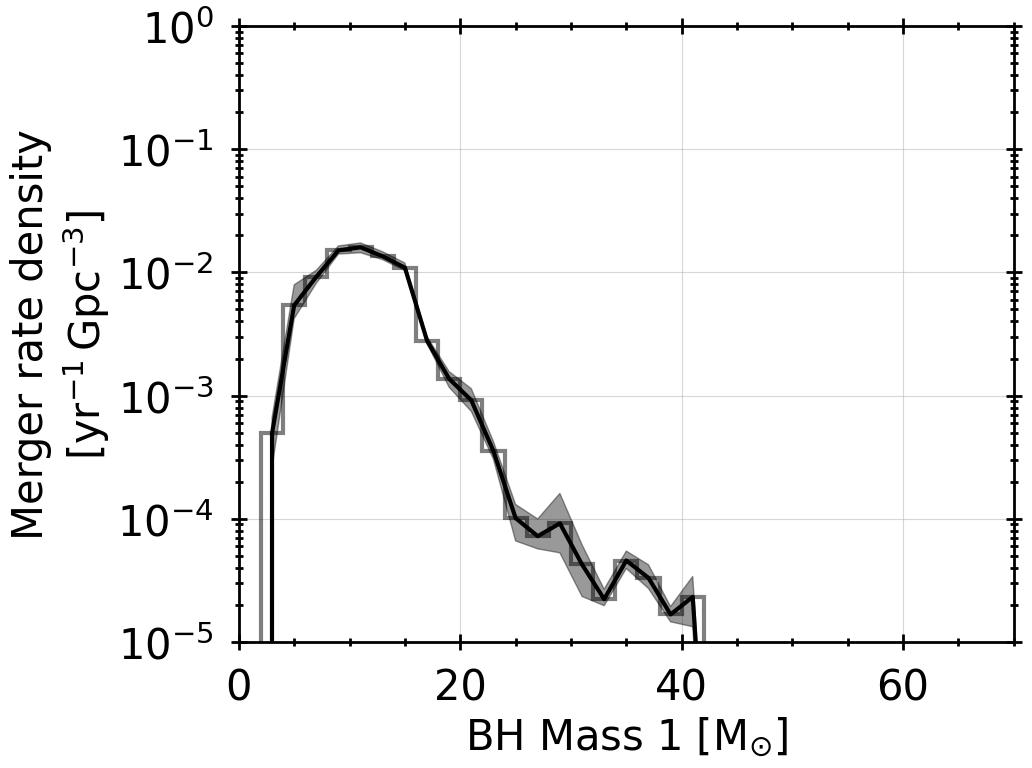

In [7]:
import matplotlib.pyplot as plt
from syntheticstellarpopconvolve.usecase_notebook_utils.usecase_gw_utils import add_confidence_interval_powerlaw_peak_primary_mass, run_bootstrap, plot_bootstrapped_data
from syntheticstellarpopconvolve.general_functions import extract_unit_dict, print_hdf5_structure

# # read out content and integrate until today
with h5py.File(convolution_config["output_filename"], "r") as output_hdf5_file:

    # lets inspect the structure within 'output_data'
    print_hdf5_structure(output_hdf5_file, subkey='output_data')

    # lets select the key
    key = "output_data/growl/intrinsic/convolution_results/0.125/"

    # extract the data and the unit dictionary
#     print(output_hdf5_file['output_data']['example']['intrinsic']['convolution_results'].keys())
    yield_data = output_hdf5_file[key+'yield'][()]
    unit_dict = extract_unit_dict(output_hdf5_file, key)



primary_mass_bins = np.arange(0, 80, 2)
primary_mass_bin_centers = (primary_mass_bins[1:]+primary_mass_bins[:-1])/2

# read in the primary masses from the original data set (not the copied one)
df = pd.read_hdf(full_path, key="input_data")
print(df.columns)


##################
# Plot data
fig, ax = plt.subplots(figsize=(10,8))

# Plot histogram of primary masses and their associated rates
# ax.hist(primary_mass_array, bins=primary_mass_bins, weights=yield_data, edgecolor='black', alpha=0.7)

# perform bootstrapping of the convolution results
median_percentile_data = run_bootstrap(
    bins=primary_mass_bins,
    bin_centers=primary_mass_bin_centers,
    rates=yield_data,
    masses=df['dco_mass_1'].values,
    bootstraps=50,
    verbose=False)

# plot the data
plot_bootstrapped_data(
    fig=fig,
    ax=ax,
    bin_centers=primary_mass_bin_centers,
    bin_edges=primary_mass_bins,
    median_percentile_data=median_percentile_data,
    label='test',
    color_i="black",
    linestyle_i="solid",
    include_hist_step=True
)

# # Add confidence interval of observations (GWTC-3).
# fig, ax = add_confidence_interval_powerlaw_peak_primary_mass(
#     fig=fig,
#     ax=ax,
#     data_root=os.path.join(os.environ["DATAFILES_ROOT"], "GW"),
#     fill_between_kwargs={},
#     add_text=True,
#     redshift=0.2,
# )

# Set axis labels and title
ax.set_xlabel('BH Mass 1 [{}]'.format(u.Msun.to_string("latex_inline")))
ax.set_ylabel('Merger rate density\n[{}]'.format(unit_dict['yield'].to_string("latex_inline")))
# ax.set_title('Merger rate density of\nmerging binary black holes at z=0')
ax.set_ylim(0.00001, 1)
ax.set_xlim(0, 70)
ax.set_yscale('log')

plt.show()

